In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.pyaudio_helper as pah
import scipy.signal as signal
import time
import sys
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('filename.png',width='80%')

# Static/Simulation-Based Audio Processing

## Notch Filters to Remove Interference
Within `sigsys` there are some handy functions for designing single section notch filters and then cascading them. First set up a scenario with tone interference present in speech.

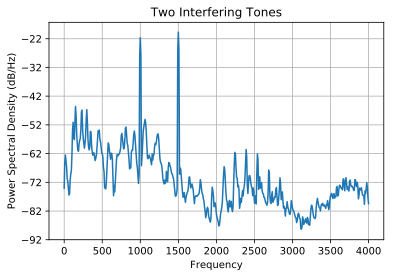

In [5]:
fs,s = ss.from_wav('OSR_us_000_0030_8k.wav')
soi = s[10000:40000]
n = arange(len(soi))
snoi = 0.4*cos(2*pi*1000/fs*n) + 0.5*cos(2*pi*1500/fs*n)
r = soi + snoi
psd(r,2**10,8000);
title(r'Two Interfering Tones');

Look at the waveform and then listen to it.

In [9]:
# First save r to a wave file for static playback
ss.to_wav('speech_tone.wav',8000,r/2)
Audio('speech_tone.wav')

Design a cascade of notch filters:

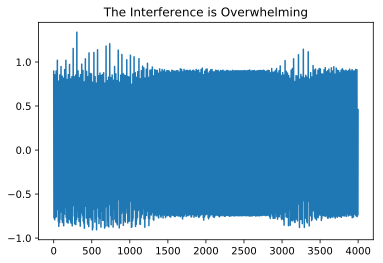

In [15]:
plot(r[6000:10000])
title(r'The Interference is Overwhelming')

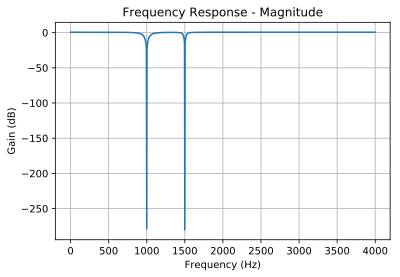

In [11]:
bn1, an1 = ss.fir_iir_notch(1000,8000)
bn2, an2 = ss.fir_iir_notch(1500,8000,.98) # tighten the bandwidth of the 12k notch
bn, an = ss.cascade_filters(bn1,an1,bn2,an2)
iir_d.freqz_resp_list([bn],[an],'dB',8000)
grid();

Now apply the filter to the composite signal::

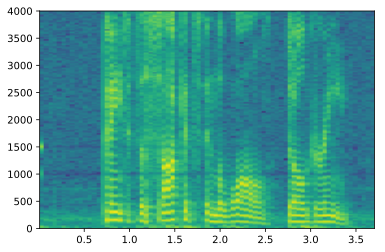

In [18]:
z = signal.lfilter(bn,an,r)
specgram(z,512,8000);

In [20]:
# First save z to a wave file for static playback
ss.to_wav('speech_tone_notch.wav',8000,z)
Audio('speech_tone_notch.wav')

## Adaptive Interference Removal
(Placeholder, but start from `ss.lms_ic`)
```python
def lms_ic(r,M,mu,delta=1):
    """
    Least mean square (LMS) interference canceller adaptive filter.

    A complete LMS adaptive filter simulation function for the case of
    interference cancellation. Used in the digital filtering case study.

    Parameters
    ----------
    M : FIR Filter length (order M-1)
    delta : Delay used to generate the reference signal
    mu : LMS step-size
    delta : decorrelation delay between input and FIR filter input

    Returns
    -------
    n : ndarray Index vector
    r : ndarray noisy (with interference) input signal
    r_hat : ndarray filtered output (NB_hat[n])
    e : ndarray error sequence (WB_hat[n])
    ao : ndarray final value of weight vector
    F : ndarray frequency response axis vector
    Ao : ndarray frequency response of filter

    Examples
    ----------
    >>> # import a speech signal
    >>> fs,s = from_wav('OSR_us_000_0030_8k.wav')
    >>> # add interference at 1kHz and 1.5 kHz and
    >>> # truncate to 5 seconds
    >>> r = soi_snoi_gen(s,10,5*8000,[1000, 1500])
    >>> # simulate with a 64 tap FIR and mu = 0.005
    >>> n,r,r_hat,e,ao,F,Ao = lms_ic(r,64,0.005)
    """
```

# Audio Special Effects
Consider *flanging*, which is a combination of a direct signal path and a time varying delay path. In `digitalcom` there is a function for creating a time-varying delay, $\beta[n]$, that works well for communication systems impairments, but is useful here as well.

Understand that a time varying delay is compressing and expanding the time axis just like the Doppler effect. In music this causes the pitch to wobble, but at slow rates introduces a whooshing effect, made popular in rock music many years ago.

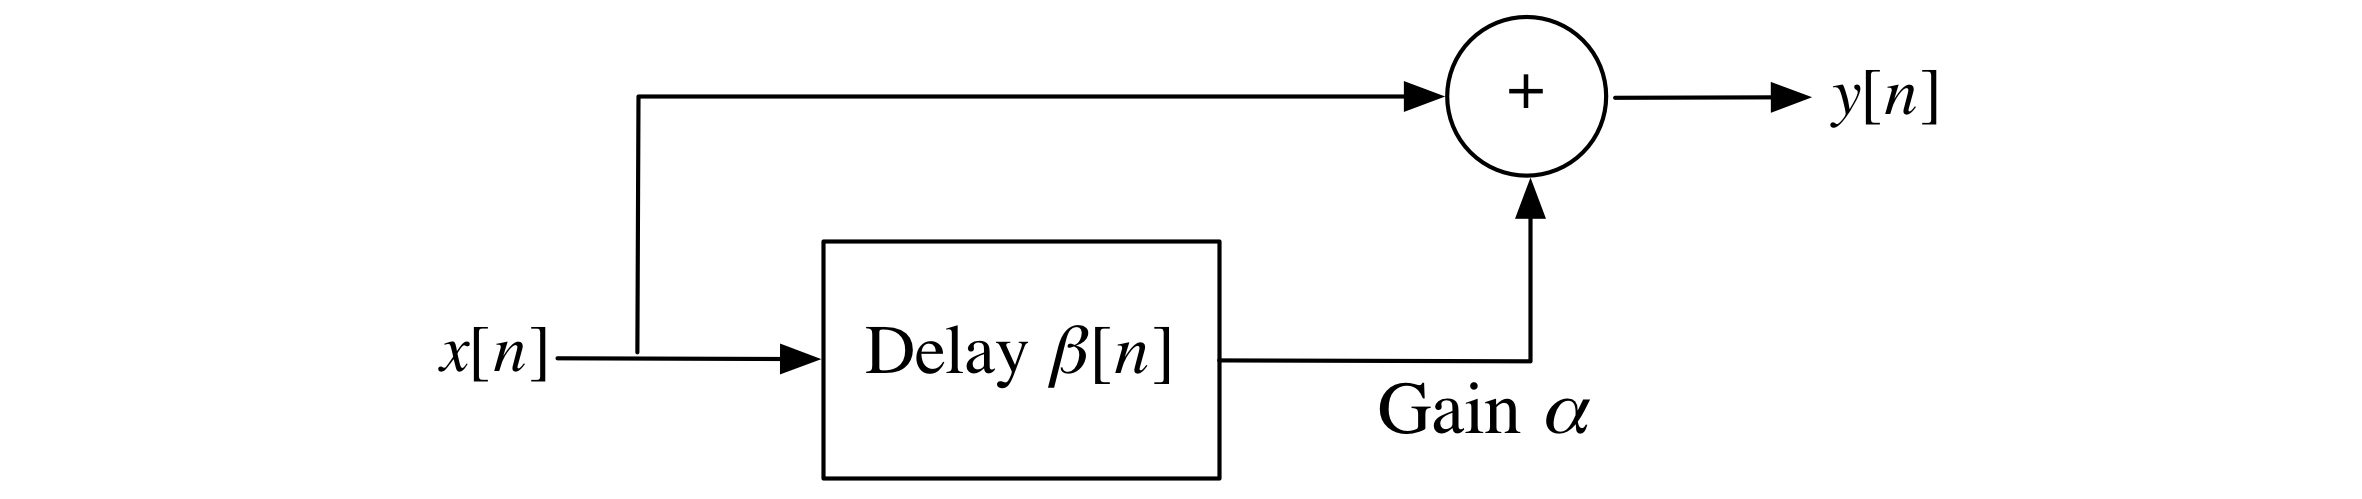

In [21]:
Image('images/Flanging_Block.png',width='80%')

The time varying delay in flanging takes the form:
$$
    \beta[n] = D_p \big(1+\cos(2\pi f_0/f_s)\big)
$$
where here $D_p = 50$ and $f_0 \simeq 1$ Hz or less.

Import some sound files and set up the time varying delay.

In [5]:
import sk_dsp_comm.digitalcom as dc # for time delay

In [34]:
Audio('c_major.wav')

In [46]:
fs,s12 = ss.from_wav('Music_Test.wav')
fs

44100

In [10]:
fs,s1 = ss.from_wav('c_major.wav')
#fs,s12 = ss.from_wav('Music_Test.wav')
#s1 = (s12[:,0] + s12[:,0])/2
n = arange(len(s1))
f0 = 1
Dp = 50
D = Dp*(1 + cos(2*pi*f0/fs*n))
x = dc.time_delay(s1,D + 2, 2*Dp+4)
x_wav = x # for PyAudio playback

#### Playback using PyAudio (one channel only)

In [8]:
# define callback
# Here we configure the callback to play back a wav file                      
def callback(in_data, frame_count, time_info, status):
    # Ignore in_data when generating output only
    #***********************************************
    global x
    # Note wav is scaled to [-1,1] so need to rescale to int16
    y = 32767*x.get_samples(frame_count)
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y)
    #***********************************************
    # Convert from float back to int16
    y = y.astype(int16)
    return y.tobytes(), pah.pyaudio.paContinue

In [11]:
x = pah.loop_audio(x_wav)
DSP_IO = pah.DSP_io_stream(callback,2,1,fs=44100,Tcapture=2)
DSP_IO.stream(10) # may need to change time

Audio input/output streaming session complete!
